# Problems with Stable distribution MLE

This relates to `mattw`'s [forum post](https://forum.pyro.ai/t/trouble-with-basic-parameter-estimation-with-the-stable-distribution/5567).

In [1]:
import matplotlib.pyplot as plt
import torch
import pyro
import pyro.distributions as dist
from pyro.distributions import constraints
from pyro.infer import SVI, Trace_ELBO
from pyro.infer.reparam import MinimalReparam
from pyro.infer.autoguide import AutoNormal, AutoGaussian

torch.set_default_dtype(torch.float64)
pyro.set_rng_seed(20230928)

In [2]:
# Define true parameters and number of datapoints
alpha = 1.4
beta = 0.8
c = 1.1
mu = 3
n = 10000

# sample data
data = dist.Stable(alpha, beta, c, mu).sample((n,))

What does the data look like?

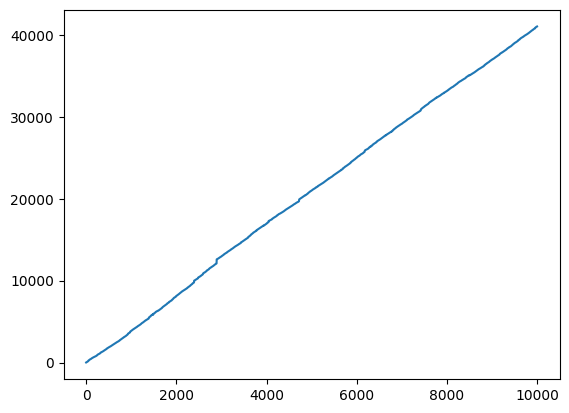

In [3]:
plt.plot(data.cumsum(0).numpy());

or subtracting the trend:

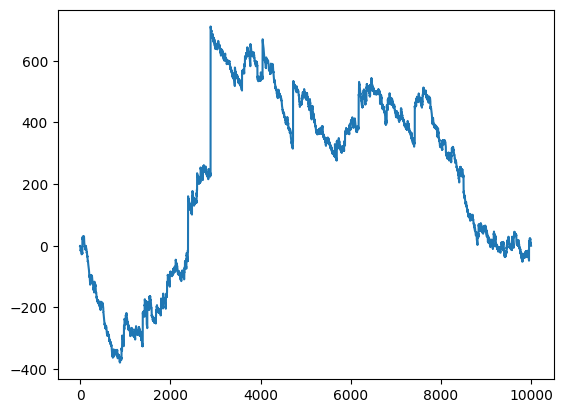

In [4]:
plt.plot((data - data.mean()).cumsum(0).numpy());

Define a simple model. Note `MinimalReparam` introduces four auxiliary latent variables.

In [5]:
@MinimalReparam()
def model(data):    
    alpha = pyro.param("alpha", torch.tensor(1.99), constraint=constraints.interval(0, 2))
    beta = pyro.param("beta", torch.tensor(0.0), constraint=constraints.interval(-1, 1))
    c = pyro.param("c", torch.tensor(1.0), constraint=constraints.positive)
    mu = pyro.param("mu", torch.tensor(0.0), constraint=constraints.real)
    with pyro.plate("data", data.shape[0]):
        pyro.sample("obs", dist.Stable(alpha, beta, c, mu), obs=data)

In [6]:
def train(model, guide, num_steps=2001, lr=0.02):
    pyro.clear_param_store()
    pyro.set_rng_seed(20230928)

    # set up ELBO, and optimizer
    elbo = Trace_ELBO()
    elbo.loss(model, guide, data=data)
    optim = pyro.optim.Adam({"lr": lr})
    svi = SVI(model, guide, optim, loss=elbo)

    # optimize
    losses = []
    for i in range(num_steps):
        loss = svi.step(data) / data.numel()
        losses.append(loss)
        if i % 100 == 0:
            print(f"step {i} loss = {loss:0.6g}")

    print(f"Parameter estimates (n = {n}):")
    print(f"alpha: Estimate = {pyro.param('alpha')}, true = {alpha}")
    print(f"beta: Estimate = {pyro.param('beta')}, true = {beta}")
    print(f"c: Estimate = {pyro.param('c')}, true = {c}")
    print(f"mu: Estimate = {pyro.param('mu')}, true = {mu}")
    return losses

First let's try fitting a diagonal `AutoNormal` guide.

In [7]:
guide = AutoNormal(model)
train(model, guide);

step 0 loss = 27.4389
step 100 loss = 6.20426
step 200 loss = 3.9673
step 300 loss = 3.47429
step 400 loss = 3.1424
step 500 loss = 2.93223
step 600 loss = 2.76516
step 700 loss = 2.63051
step 800 loss = 2.54689
step 900 loss = 2.51148
step 1000 loss = 2.50159
step 1100 loss = 2.49952
step 1200 loss = 2.49274
step 1300 loss = 2.50508
step 1400 loss = 2.49462
step 1500 loss = 2.48225
step 1600 loss = 2.48826
step 1700 loss = 2.49166
step 1800 loss = 2.49833
step 1900 loss = 2.5059
step 2000 loss = 2.50605
Parameter estimates (n = 10000):
alpha: Estimate = 1.5808823674323638, true = 1.4
beta: Estimate = -0.0013091968632371609, true = 0.8
c: Estimate = 1.2189916616873966, true = 1.1
mu: Estimate = 3.349987673604992, true = 3


It looks like `beta` is especially way off.

Next let's create a guide with correlations among the 4 auxiliary variables for each datum, but no correlations across the plate.  We'll use [easy_guide](https://pyro.ai/examples/easyguide.html).

In [8]:
from pyro.contrib.easyguide import easy_guide

@easy_guide(model)
def guide2(self, data):
    # Match all auxiliary variables introduced by StableReparam:
    # https://github.com/pyro-ppl/pyro/blob/1.8.6/pyro/infer/reparam/stable.py#L194
    group = self.group(match="obs_.*")
    assert group.event_shape == (4,)
    d = group.event_shape.numel()
    
    # Use the same parametrization as in AutoMultivariateNormal, but batched.
    loc = pyro.param("guide_loc", lambda: torch.zeros(data.shape + (d,)))
    scale = pyro.param("guide_scale", lambda: torch.full_like(loc, 0.01),
                       constraint=constraints.softplus_positive)
    scale_tril = pyro.param(
        "guide_scale_tril",
        lambda: torch.eye(d) + torch.zeros(data.shape + (1, 1)),
        constraint=constraints.unit_lower_cholesky)
    scale_tril = scale[..., None] * scale_tril
    mvn = dist.MultivariateNormal(loc, scale_tril=scale_tril)

    with self.plate("data", data.shape[0]):
        group.sample("aux_vars", mvn)

In [9]:
train(model, guide2);

step 0 loss = 36.6272
step 100 loss = 13.8026
step 200 loss = 6.68958
step 300 loss = 3.94441
step 400 loss = 3.26316
step 500 loss = 3.03408
step 600 loss = 2.8175
step 700 loss = 2.67369
step 800 loss = 2.60301
step 900 loss = 2.55999
step 1000 loss = 2.52772
step 1100 loss = 2.52596
step 1200 loss = 2.52203
step 1300 loss = 2.52361
step 1400 loss = 2.52335
step 1500 loss = 2.49618
step 1600 loss = 2.51197
step 1700 loss = 2.52333
step 1800 loss = 2.51975
step 1900 loss = 2.53171
step 2000 loss = 2.50771
Parameter estimates (n = 10000):
alpha: Estimate = 1.452168661974191, true = 1.4
beta: Estimate = -0.0006795531391183829, true = 0.8
c: Estimate = 1.171598434074417, true = 1.1
mu: Estimate = 3.3039801341398025, true = 3


Hmm, this still doesn't fit very well.